In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
torch.cuda.is_available()

True

In [4]:
df = pd.read_csv('../PYTORCH_NOTEBOOKS/Data/income.csv')

In [5]:
df.head()

,age,sex,education,education-num,marital-status,workclass,occupation,hours-per-week,income,label
0,27,Male,HS-grad,9,Never-married,Private,Craft-repair,40,<=50K,0
1,47,Male,Masters,14,Married,Local-gov,Exec-managerial,50,>50K,1
2,59,Male,HS-grad,9,Divorced,Self-emp,Prof-specialty,20,<=50K,0
3,38,Female,Prof-school,15,Never-married,Federal-gov,Prof-specialty,57,>50K,1
4,64,Female,11th,7,Widowed,Private,Farming-fishing,40,<=50K,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             30000 non-null  int64 
 1   sex             30000 non-null  object
 2   education       30000 non-null  object
 3   education-num   30000 non-null  int64 
 4   marital-status  30000 non-null  object
 5   workclass       30000 non-null  object
 6   occupation      30000 non-null  object
 7   hours-per-week  30000 non-null  int64 
 8   income          30000 non-null  object
 9   label           30000 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 2.3+ MB


In [7]:
for i in df.columns:
    print(f'column: {i}--------> unique_value: {df[i].nunique()}')

column: age--------> unique_value: 72
column: sex--------> unique_value: 2
column: education--------> unique_value: 14
column: education-num--------> unique_value: 14
column: marital-status--------> unique_value: 6
column: workclass--------> unique_value: 5
column: occupation--------> unique_value: 12
column: hours-per-week--------> unique_value: 60
column: income--------> unique_value: 2
column: label--------> unique_value: 2


In [8]:
df.columns

Index(['age', 'sex', 'education', 'education-num', 'marital-status',
       'workclass', 'occupation', 'hours-per-week', 'income', 'label'],
      dtype='object')

In [9]:
category_columns = ['sex', 'education', 'marital-status', 'workclass', 'occupation', 'income']
y_col = ['label']

In [10]:
continueous_columns = []
for i in df.columns:
    if i in category_columns:
        pass
    elif i in y_col:
        pass
    else:
        continueous_columns.append(i)

In [11]:
continueous_columns

['age', 'education-num', 'hours-per-week']

In [12]:
from sklearn.preprocessing import LabelEncoder

In [13]:
label_encoder = LabelEncoder()

In [14]:
for i in category_columns:
    df[i] = label_encoder.fit_transform(df[i])

In [15]:
df.head()

,age,sex,education,education-num,marital-status,workclass,occupation,hours-per-week,income,label
0,27,1,10,9,3,2,1,40,0,0
1,47,1,11,14,1,1,2,50,1,1
2,59,1,10,9,0,3,7,20,0,0
3,38,0,12,15,3,0,7,57,1,1
4,64,0,1,7,5,2,3,40,0,0


In [16]:
import numpy as np

In [17]:
category_features = torch.tensor(np.stack([df[i].values for i in category_columns], axis = 1), dtype = torch.int64)

In [18]:
category_features

tensor([[ 1, 10,  3,  2,  1,  0],
        [ 1, 11,  1,  1,  2,  1],
        [ 1, 10,  0,  3,  7,  0],
        ...,
        [ 1, 12,  1,  2,  7,  1],
        [ 0, 13,  3,  2,  0,  0],
        [ 1,  6,  1,  3,  2,  1]])

In [19]:
continueous_features = torch.tensor(np.stack([df[i].values for i in continueous_columns], axis = 1),dtype = torch.float)

In [20]:
continueous_features

tensor([[27.,  9., 40.],
        [47., 14., 50.],
        [59.,  9., 20.],
        ...,
        [47., 15., 55.],
        [32., 10., 40.],
        [33., 12., 60.]])

In [21]:
y = torch.tensor(df[y_col].values).flatten()

In [22]:
y

tensor([0, 1, 0,  ..., 1, 0, 1])

In [23]:
b = 30000
t = 5000

cat_train = category_features[:b-t].cuda()
cat_test = category_features[b-t:b].cuda()
cont_train = continueous_features[:b-t].cuda()
cont_test = continueous_features[b-t:b].cuda()

y_train = y[:b-t].cuda()
y_test = y[b-t:b].cuda()

In [24]:
cat_size = [df[i].nunique() for i in category_columns ]
embedding_size = [(size, min(50, (size+1)//2)) for size in cat_size]

In [25]:
embedding_size

[(2, 1), (14, 7), (6, 3), (5, 3), (12, 6), (2, 1)]

In [26]:
class TModel(nn.Module):
    def __init__(self,embed_sz, n_cont, out_sz, layers, p=0.50):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(i,o) for i,o in embedding_size])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        n_emb = sum((o for i,o in embedding_size))
        n_in = n_cont + n_emb
        
        layerlist = []
        for i in layers:
            layerlist.append(nn.Linear(n_in, i))
            layerlist.append(nn.ReLU(inplace = True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
            
        layerlist.append(nn.Linear(layers[-1], out_sz))
        self.layers = nn.Sequential(*layerlist)
        
    def forward(self,x_cat,x_cont):
        embeddings = []
        for i,o in enumerate(self.embeds):
            embeddings.append(o(x_cat[:,i]))
        x = torch.cat(embeddings, axis = 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x,x_cont], axis = 1)
        x = self.layers(x)
        
        return x

In [27]:
torch.manual_seed(33)
my_model = TModel(embedding_size, continueous_features.shape[1], 2, [50,20,10], p=0.4)

In [28]:
my_model = my_model.cuda()

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(my_model.parameters(), lr = 0.001)

In [30]:
import time 
start_time = time.time()
epochs = 500
losses = []

for i in range(epochs):
    y_pred = my_model(cat_train,cont_train)
    
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    
    if i%10 ==1:
        print(f'epochs: {i} loss: {loss.item()}')
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
print(f'epochs: {i} loss: {loss.item()}')
print(f"time: {(time.time()-start_time)/60} mins")

epochs: 1 loss: 0.743656575679779
epochs: 11 loss: 0.6786283850669861
epochs: 21 loss: 0.639193058013916
epochs: 31 loss: 0.6043787598609924
epochs: 41 loss: 0.5693156719207764
epochs: 51 loss: 0.5370675921440125
epochs: 61 loss: 0.503231942653656
epochs: 71 loss: 0.46990981698036194
epochs: 81 loss: 0.43580204248428345
epochs: 91 loss: 0.39429330825805664
epochs: 101 loss: 0.3693001866340637
epochs: 111 loss: 0.3255128562450409
epochs: 121 loss: 0.30492734909057617
epochs: 131 loss: 0.2785167098045349
epochs: 141 loss: 0.26298046112060547
epochs: 151 loss: 0.2407107800245285
epochs: 161 loss: 0.23008829355239868
epochs: 171 loss: 0.22608238458633423
epochs: 181 loss: 0.20448608696460724
epochs: 191 loss: 0.19882647693157196
epochs: 201 loss: 0.19330941140651703
epochs: 211 loss: 0.1884610503911972
epochs: 221 loss: 0.18320126831531525
epochs: 231 loss: 0.18006548285484314
epochs: 241 loss: 0.17544250190258026
epochs: 251 loss: 0.17119263112545013
epochs: 261 loss: 0.16749073565006256


Text(0, 0.5, 'loss')

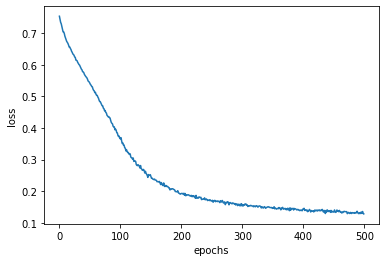

In [31]:
plt.plot(range(epochs),losses)
plt.xlabel('epochs')
plt.ylabel('loss')

In [32]:
with torch.no_grad():
    y_val = my_model(cat_test,cont_test)
    loss = criterion(y_val, y_test)
print(f'loss: {loss}')

loss: 0.1352299004793167


In [33]:
count = 50
correct = 0

print(f'{"model_output":26} predicted_y test_y')

for i in range(count):
    print(f'{str(y_val[i]):26} {y_val[i].argmax():^9} {y_test[i]:^9}')
    if y_val[i].argmax().item() == y_test[i]:
        correct+=1
print(f'\n{correct} out of {i} = {100*correct/i:.2f}% correct')

model_output               predicted_y test_y
tensor([-0.9557,  0.4852], device='cuda:0')     1         1    
tensor([ 1.5871, -0.9286], device='cuda:0')     0         0    
tensor([-4.1142,  3.5873], device='cuda:0')     1         1    
tensor([ 2.4902, -3.3146], device='cuda:0')     0         0    
tensor([ 3.5185, -2.6831], device='cuda:0')     0         0    
tensor([ 1.1248, -1.7839], device='cuda:0')     0         0    
tensor([ 3.4088, -5.2050], device='cuda:0')     0         0    
tensor([ 4.5535, -4.8769], device='cuda:0')     0         0    
tensor([ 3.7625, -3.6417], device='cuda:0')     0         0    
tensor([ 2.4956, -3.3952], device='cuda:0')     0         0    
tensor([ 1.4234, -2.3689], device='cuda:0')     0         0    
tensor([-2.6896,  1.8659], device='cuda:0')     1         1    
tensor([-2.8494,  1.7350], device='cuda:0')     1         1    
tensor([ 0.5762, -1.4096], device='cuda:0')     0         0    
tensor([ 2.6410, -3.0076], device='cuda:0')     0         

In [34]:
torch.save(my_model.state_dict(), 'Cencus_income.pt')